## Model Training

Having preprocessed the dataset, this notebook builds and trains an ANN, hopefully be able to classify transaction category and achieve decent result.

#### Import Libraries

I'll be using the PyTorch framework to build and train the ANN. 

In [13]:

import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#### Load & Prepare Data

In [15]:
# Load the preprocessed data
df = pd.read_csv("../dataset/preprocessed_bank_transaction.csv")

# Extract all feature columns that are not prefixed with "category_"
feature_columns = [col for col in df.columns if not col.startswith("category_")]
X = df[feature_columns].values
print(X.shape)

(258522, 111)


In [16]:
# Extract all category columns
y = df.filter(like="category_").values 
print(y.shape)

(258522, 33)


#### Splitting into Training and Testing Set

The dataset will be splitted into 70% training and 30% testing set


In [17]:
# Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float for BCE loss
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

# Print dataset shapes
print("Shape of X_train:", X_train_tensor.shape)
print("Shape of X_test:", X_test_tensor.shape)
print("Shape of y_train:", y_train_tensor.shape)
print("Shape of y_test:", y_test_tensor.shape)


Shape of X_train: torch.Size([180965, 111])
Shape of X_test: torch.Size([77557, 111])
Shape of y_train: torch.Size([180965, 33])
Shape of y_test: torch.Size([77557, 33])


#### Define the ANN Architecture

Since this is a multi-class classification problem (one-hot encoded category labels):

- Use fully connected layers
- Apply Batch Normalization for stable training
- Use Dropout to prevent overfitting
- Use Sigmoid activation at the output

In [18]:
# Define the ANN model
class TransactionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TransactionClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)  # Second hidden layer
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, num_classes)  # Output layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for multi-label classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid for multi-label output
        return x

#### Load the Class Weights

The class weights have been calculated and saved during data preprocessing. It's can be used to adjust model weights later to deal with class imbalance if `use_class_weight` parameter is set to `True`.

In [19]:
import pickle

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the saved class weights
CLASS_WEIGHTS_PATH = "../models/class_weights/class_weights.pkl"

# Load the class weights
with open(CLASS_WEIGHTS_PATH, "rb") as f:
    class_weights_dict = pickle.load(f)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32).to(device)

#### Model Initialisation Function

- The argument `use_class_weights` determine whether to use **custom weighted** BCE loss to adjust the model weights for each class, or use the standard `BCELoss()` for training.
- Use Adam optimiser with learning rate 0.001

In [20]:
import torch.optim as optim
import torch.nn as nn

def initialize_model(input_size, num_classes, use_class_weights=False, class_weights=None, learning_rate=0.001):
    """Initialize the model, optimizer, and loss function with optional class weights."""
    
    # Initialize model
    model = TransactionClassifier(input_size, num_classes).to(device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define custom weighted BCE loss function
    def weighted_bce_loss(outputs, targets):
        """Applies class weights to BCEWithLogitsLoss."""
        loss = nn.BCELoss(reduction='none')(outputs, targets)  # Compute loss per class
        weighted_loss = loss * class_weights.to(device)  # Apply class weights
        return weighted_loss.mean()  # Return mean loss

    # Use weighted BCE loss if class weights are provided, else use standard BCE loss
    if use_class_weights and class_weights is not None:
        loss_fn = weighted_bce_loss
    else:
        loss_fn = nn.BCELoss()

    return model, optimizer, loss_fn


#### Initialising Model

In [ ]:
# Example input and output size
input_size = X_train.shape[1]  # Total number of input features
num_classes = y_train.shape[1]  # Number of categories

use_class_weights = False

model, optimizer, loss_fn = initialize_model(
    input_size,
    num_classes,
    use_class_weights,
    class_weights=class_weights_tensor
)

# Print model summary
print(model)


TransactionClassifier(
  (fc1): Linear(in_features=111, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
  (sigmoid): Sigmoid()
)


#### Define Utility Functions

- Plot train vs test loss & accuracy over epochs
- Visualise confusion matrix & classification report
- Save model if `save_results` argument is `True`

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs, save_results, model_name):
    """Plot Train vs Test Loss & Accuracy side by side and optionally save results."""
    epochs = range(1, num_epochs+1)

    # Create side-by-side plots
    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    # Plot Loss vs Epoch
    ax[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    ax[0].plot(epochs, test_losses, label='Test Loss', marker='s')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss vs Test Loss')
    ax[0].legend()

    # Plot Accuracy vs Epoch
    ax[1].plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    ax[1].plot(epochs, test_accuracies, label='Test Accuracy', marker='s')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Train Accuracy vs Test Accuracy')
    ax[1].legend()

    if save_results:
        plt.savefig(f"../results/{model_name}/training_metrics.png")
        print(f"Training metrics saved at: ../results/{model_name}/training_metrics.png")

    plt.show()


def plot_confusion_matrix(all_labels, all_preds, category_names, save_results, model_name):
    """Compute and visualize the confusion matrix & classification report with real category names."""
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=category_names)

    # Increase figure size and use tight_layout
    fig, ax = plt.subplots(figsize=(14, 10))  # Adjust width and height if needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names, ax=ax)
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(category_names, rotation=90, ha="right")  # Rotate labels for better visibility
    ax.set_yticklabels(category_names, rotation=0)

    # Adjust layout to prevent cropping
    plt.tight_layout() 

    if save_results:
        save_path = f"../results/{model_name}/confusion_matrix.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)  # Save with bbox_inches to prevent cropping
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

    # Print classification report
    print(report)

    # Save classification report
    if save_results:
        with open(f"../results/{model_name}/classification_report.txt", "w") as f:
            f.write(report)
        print(f"Classification report saved at: ../results/{model_name}/classification_report.txt")


def save_model(model, model_name):
    """Save trained model and create directories."""
    # Create directories
    os.makedirs("../models/ann", exist_ok=True)
    os.makedirs(f"../results/{model_name}", exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), f"../models/ann/{model_name}.pth")
    print(f"Model saved at: ../models/ann/{model_name}.pth")


#### Define Train Test Function

- Train the model for an epoch.
- Evaluate the model on the test set after each epoch.
- Print Train Accuracy, Train Loss, Test Accuracy, and Test Loss.

In [23]:
import torch
from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, category_names, model_name, save_results, num_epochs=20, device="cpu"):
    model.to(device)

    # Lists to store loss and accuracy for visualization
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        for batch_X, batch_y in train_progress:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute loss
            running_train_loss += loss.item()

            # Compute instance-level accuracy
            predicted_classes = torch.argmax(outputs, dim=1)
            true_classes = torch.argmax(batch_y, dim=1)
            correct_train += (predicted_classes == true_classes).sum().item()
            total_train += batch_y.size(0)  # Number of transactions

            train_progress.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            test_progress = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Evaluating]", leave=False)
            for batch_X, batch_y in test_progress:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                outputs = model(batch_X)
                loss = loss_fn(outputs, batch_y)
                running_test_loss += loss.item()

                # Compute instance-level accuracy
                predicted_classes = torch.argmax(outputs, dim=1)
                true_classes = torch.argmax(batch_y, dim=1)
                correct_test += (predicted_classes == true_classes).sum().item()
                total_test += batch_y.size(0)

                test_progress.set_postfix(loss=loss.item())

                # Store predictions for confusion matrix
                all_preds.extend(predicted_classes.cpu().numpy())
                all_labels.extend(true_classes.cpu().numpy())

        avg_test_loss = running_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    print("Training complete!")
    
    # Save Model & Results if save_results=True
    if save_results:
        save_model(model, model_name)

    # Plot Loss & Accuracy Side by Side
    plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs, save_results, model_name)

    # Plot Confusion Matrix with Real Category Names
    plot_confusion_matrix(all_labels, all_preds, category_names, save_results, model_name)


#### Train and Evaluate Model

Epoch [1/50] - Train Loss: 0.4544, Train Acc: 0.5087, Test Loss: 0.1040, Test Acc: 0.6533


Epoch [2/50] - Train Loss: 0.0973, Train Acc: 0.6040, Test Loss: 0.0988, Test Acc: 0.6622


Epoch [3/50] - Train Loss: 0.0895, Train Acc: 0.6192, Test Loss: 0.0942, Test Acc: 0.6731


Epoch [4/50] - Train Loss: 0.0888, Train Acc: 0.6287, Test Loss: 0.1004, Test Acc: 0.6791


Epoch [5/50] - Train Loss: 0.0846, Train Acc: 0.6341, Test Loss: 0.0940, Test Acc: 0.6868


Epoch [6/50] - Train Loss: 0.0816, Train Acc: 0.6397, Test Loss: 0.1037, Test Acc: 0.6934


Epoch [7/50] - Train Loss: 0.0789, Train Acc: 0.6439, Test Loss: 0.0941, Test Acc: 0.6967


Epoch [8/50] - Train Loss: 0.0751, Train Acc: 0.6490, Test Loss: 0.1058, Test Acc: 0.6958


Epoch [9/50] - Train Loss: 0.0792, Train Acc: 0.6498, Test Loss: 0.0928, Test Acc: 0.6955


Epoch [10/50] - Train Loss: 0.0751, Train Acc: 0.6531, Test Loss: 0.0958, Test Acc: 0.7002


Epoch [11/50] - Train Loss: 0.0725, Train Acc: 0.6556, Test Loss: 0.0972, Test Acc: 0.7049


Epoch [12/50] - Train Loss: 0.0715, Train Acc: 0.6583, Test Loss: 0.0968, Test Acc: 0.7070


Epoch [13/50] - Train Loss: 0.0721, Train Acc: 0.6609, Test Loss: 0.0921, Test Acc: 0.7096


Epoch [14/50] - Train Loss: 0.0666, Train Acc: 0.6623, Test Loss: 0.0966, Test Acc: 0.7114


Epoch [15/50] - Train Loss: 0.0700, Train Acc: 0.6636, Test Loss: 0.0977, Test Acc: 0.7090


Epoch [16/50] - Train Loss: 0.0668, Train Acc: 0.6659, Test Loss: 0.0909, Test Acc: 0.7134


Epoch [17/50] - Train Loss: 0.0666, Train Acc: 0.6682, Test Loss: 0.0971, Test Acc: 0.7184


Epoch [18/50] - Train Loss: 0.0655, Train Acc: 0.6696, Test Loss: 0.0960, Test Acc: 0.7164


Epoch [19/50] - Train Loss: 0.0677, Train Acc: 0.6708, Test Loss: 0.0956, Test Acc: 0.7167


Epoch [20/50] - Train Loss: 0.0642, Train Acc: 0.6715, Test Loss: 0.0992, Test Acc: 0.7193


Epoch [21/50] - Train Loss: 0.0647, Train Acc: 0.6721, Test Loss: 0.0986, Test Acc: 0.7104


Epoch [22/50] - Train Loss: 0.0644, Train Acc: 0.6730, Test Loss: 0.0972, Test Acc: 0.7195


Epoch [23/50] - Train Loss: 0.0632, Train Acc: 0.6755, Test Loss: 0.0974, Test Acc: 0.7212


Epoch [24/50] - Train Loss: 0.0644, Train Acc: 0.6779, Test Loss: 0.0922, Test Acc: 0.7225


Epoch [25/50] - Train Loss: 0.0611, Train Acc: 0.6785, Test Loss: 0.0965, Test Acc: 0.7225


Epoch [26/50] - Train Loss: 0.0620, Train Acc: 0.6795, Test Loss: 0.1028, Test Acc: 0.7250


Epoch [27/50] - Train Loss: 0.0626, Train Acc: 0.6799, Test Loss: 0.0991, Test Acc: 0.7271


Epoch [28/50] - Train Loss: 0.0613, Train Acc: 0.6807, Test Loss: 0.0952, Test Acc: 0.7240


Epoch [29/50] - Train Loss: 0.0609, Train Acc: 0.6817, Test Loss: 0.0976, Test Acc: 0.7279


Epoch [30/50] - Train Loss: 0.0613, Train Acc: 0.6823, Test Loss: 0.1036, Test Acc: 0.7234


Epoch [31/50] - Train Loss: 0.0592, Train Acc: 0.6840, Test Loss: 0.1010, Test Acc: 0.7258


Epoch [32/50] - Train Loss: 0.0606, Train Acc: 0.6840, Test Loss: 0.0978, Test Acc: 0.7285


Epoch [33/50] - Train Loss: 0.0579, Train Acc: 0.6836, Test Loss: 0.0999, Test Acc: 0.7233


Epoch [34/50] - Train Loss: 0.0586, Train Acc: 0.6858, Test Loss: 0.1063, Test Acc: 0.7260


Epoch [35/50] - Train Loss: 0.0598, Train Acc: 0.6868, Test Loss: 0.0953, Test Acc: 0.7235


Epoch [36/50] - Train Loss: 0.0574, Train Acc: 0.6897, Test Loss: 0.0994, Test Acc: 0.7324


Epoch [37/50] - Train Loss: 0.0579, Train Acc: 0.6890, Test Loss: 0.0941, Test Acc: 0.7246


Epoch [38/50] - Train Loss: 0.0570, Train Acc: 0.6908, Test Loss: 0.1010, Test Acc: 0.7325


Epoch [39/50] - Train Loss: 0.0597, Train Acc: 0.6892, Test Loss: 0.0988, Test Acc: 0.7322


Epoch [40/50] - Train Loss: 0.0582, Train Acc: 0.6911, Test Loss: 0.0973, Test Acc: 0.7303


Epoch [41/50] - Train Loss: 0.0576, Train Acc: 0.6906, Test Loss: 0.1026, Test Acc: 0.7328


Epoch [42/50] - Train Loss: 0.0572, Train Acc: 0.6922, Test Loss: 0.1019, Test Acc: 0.7328


Epoch [43/50] - Train Loss: 0.0567, Train Acc: 0.6911, Test Loss: 0.1047, Test Acc: 0.7347


Epoch [44/50] - Train Loss: 0.0564, Train Acc: 0.6934, Test Loss: 0.1065, Test Acc: 0.7373


Epoch [45/50] - Train Loss: 0.0562, Train Acc: 0.6937, Test Loss: 0.1019, Test Acc: 0.7410


Epoch [46/50] - Train Loss: 0.0566, Train Acc: 0.6944, Test Loss: 0.0997, Test Acc: 0.7405


Epoch [47/50] - Train Loss: 0.0560, Train Acc: 0.6954, Test Loss: 0.1043, Test Acc: 0.7155


Epoch [48/50] - Train Loss: 0.0556, Train Acc: 0.6964, Test Loss: 0.1004, Test Acc: 0.7444


Epoch [49/50] - Train Loss: 0.0570, Train Acc: 0.6955, Test Loss: 0.1009, Test Acc: 0.7373


Epoch [50/50] - Train Loss: 0.0549, Train Acc: 0.6952, Test Loss: 0.1046, Test Acc: 0.7448
Training complete!
Model saved at: ../models/ann/ANN_50e_1e-3lr_wbce_classifier.pth
Training metrics saved at: ../results/ANN_50e_1e-3lr_wbce_classifier/training_metrics.png


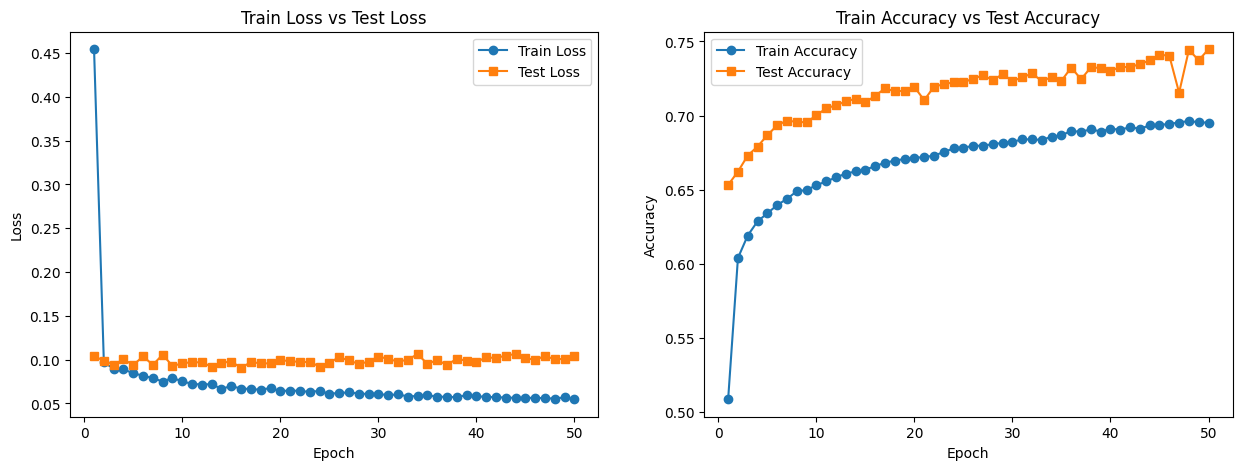

Confusion matrix saved at: ../results/ANN_50e_1e-3lr_wbce_classifier/confusion_matrix.png


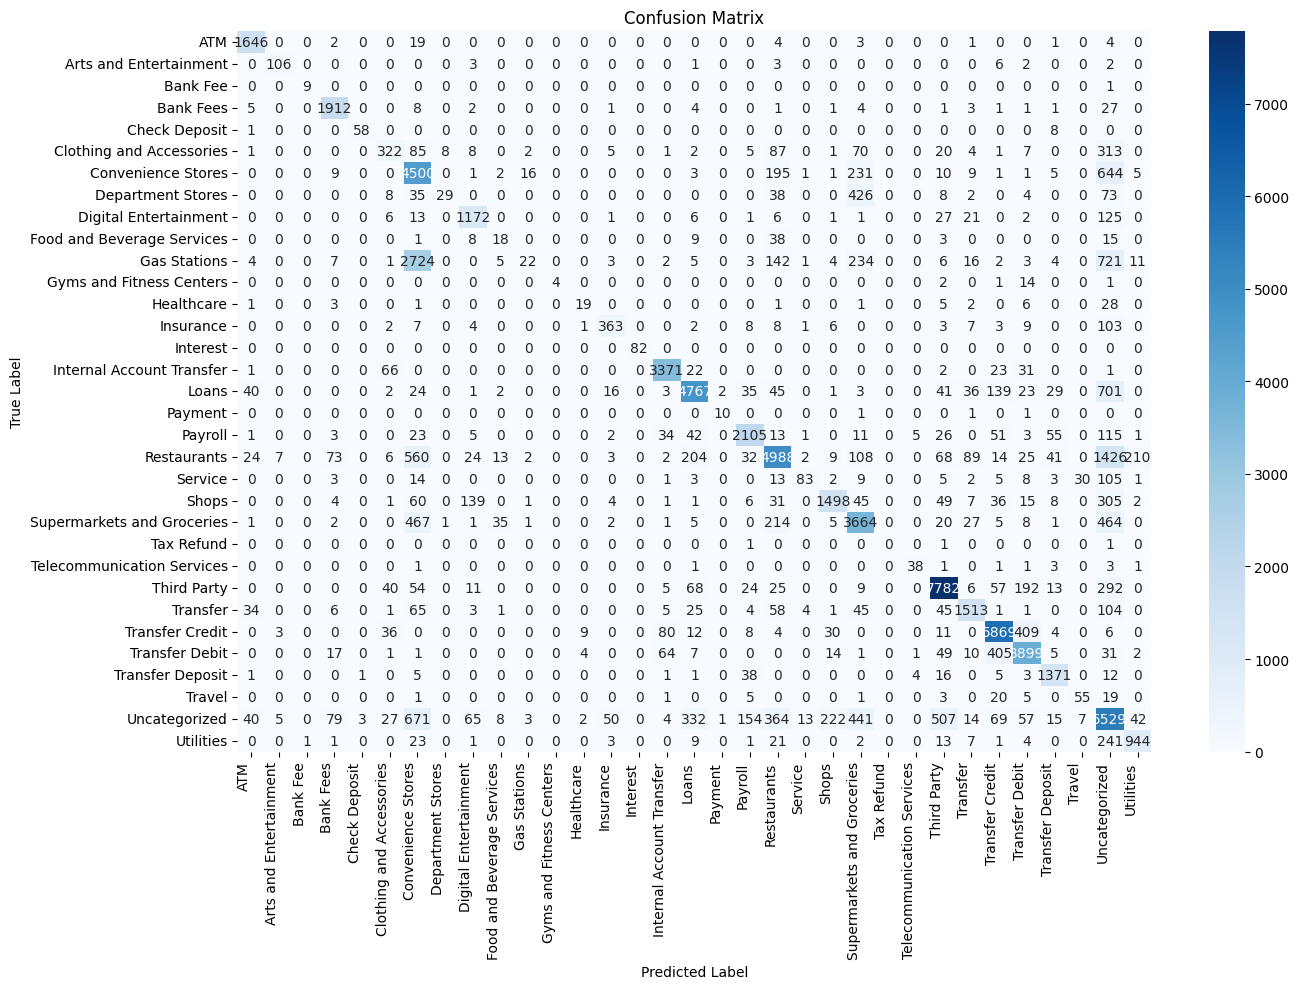

                            precision    recall  f1-score   support

                       ATM       0.91      0.98      0.95      1680
    Arts and Entertainment       0.88      0.86      0.87       123
                  Bank Fee       0.90      0.90      0.90        10
                 Bank Fees       0.90      0.97      0.93      1972
             Check Deposit       0.94      0.87      0.90        67
  Clothing and Accessories       0.62      0.34      0.44       942
        Convenience Stores       0.48      0.80      0.60      5634
         Department Stores       0.76      0.05      0.09       623
     Digital Entertainment       0.81      0.85      0.83      1382
Food and Beverage Services       0.21      0.20      0.20        92
              Gas Stations       0.47      0.01      0.01      3920
  Gyms and Fitness Centers       1.00      0.18      0.31        22
                Healthcare       0.54      0.28      0.37        67
                 Insurance       0.80      0.69

In [ ]:
category_columns = [col for col in df.columns if col.startswith("category_")]
category_names = [col.replace("category_", "").replace("_", " ") for col in category_columns]  # Remove 'category_' prefix

model_name = "ANN_50e_1e-3lr_bce_classifier"

# Train and evaluate the model
train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, category_names, model_name, save_results=False, num_epochs=50, device=device)